## 根据用户喜好推荐电影

根据用户喜好推荐电影，是通过计算用户特征和电影特征之间的相似性，并排序选取相似度最大的结果来进行推荐，流程如下：
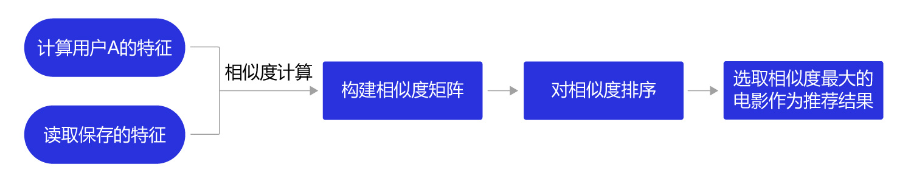


从计算相似度到完成推荐的过程，步骤包括：

1. 读取保存的特征，根据一个给定的用户ID、电影ID，我们可以索引到对应的特征向量。
2. 通过计算用户特征和其他电影特征向量的相似度，构建相似度矩阵。
3. 对这些相似度排序后，选取相似度最大的几个特征向量，找到对应的电影ID，即得到推荐清单。
4. 加入随机选择因素，从相似度最大的top_k结果中随机选取pick_num个推荐结果，其中pick_num必须小于top_k。

In [5]:
import paddle

import numpy as np
import pickle

# 封装电影推荐函数
def recommend_mov_for_usr(usr_id, top_k, pick_num, usr_feat_dir, mov_feat_dir, mov_info_path):
    assert pick_num <= top_k
    
    # 读取电影和用户的特征
    usr_feats = pickle.load(open(usr_feat_dir, 'rb'))
    mov_feats = pickle.load(open(mov_feat_dir, 'rb'))
    usr_feat = usr_feats[str(usr_id)]

    cos_sims = []

    # with dygraph.guard():
    paddle.disable_static()
    
    # 索引电影特征，计算和输入用户ID的特征的相似度
    for idx, key in enumerate(mov_feats.keys()):
        mov_feat = mov_feats[key]
        usr_feat = paddle.to_tensor(usr_feat)
        mov_feat = paddle.to_tensor(mov_feat)
        
        # 计算余弦相似度
        sim = paddle.nn.functional.common.cosine_similarity(usr_feat, mov_feat)
        cos_sims.append(sim.numpy()[0])
        
    # 对相似度排序
    index = np.argsort(cos_sims)[-top_k:]
    
    # 读取电影文件里的数据，根据电影ID索引到电影信息
    mov_info = {}
    with open(mov_info_path, 'r', encoding="ISO-8859-1") as f:
        data = f.readlines()
        for item in data:
            item = item.strip().split("::")
            mov_info[str(item[0])] = item
            
    print("当前的用户ID：", usr_id)
    print("\n向其推荐的电影是：")
    res = []
    
    # 加入随机选择因素，确保每次推荐的都不一样
    while len(res) < pick_num:
        val = np.random.choice(len(index), 1)[0]
        idx = index[val]
        mov_id = list(mov_feats.keys())[idx]
        if mov_id not in res:
            res.append(mov_id)

    for id in res:
        print("mov_id:", id, mov_info[str(id)])

In [8]:
# 推荐测试
movie_data_path = '../datasets/ml-1m/movies.dat'
usr_feat_path = '../models/usr_feat.pkl'
mov_feat_path = '../models/mov_feat.pkl'

top_k, pick_num = 10, 6
usr_id = 1

recommend_mov_for_usr(usr_id, top_k, pick_num, usr_feat_path, mov_feat_path, movie_data_path)

当前的用户ID： 1

向其推荐的电影是：
mov_id: 3772 ['3772', 'Hatchet For the Honeymoon (Rosso Segno Della Follia) (1969)', 'Horror']
mov_id: 2527 ['2527', 'Westworld (1973)', 'Action|Sci-Fi|Thriller|Western']
mov_id: 3859 ['3859', 'Eyes of Tammy Faye, The (2000)', 'Documentary']
mov_id: 991 ['991', 'Michael Collins (1996)', 'Drama|War']
mov_id: 969 ['969', 'African Queen, The (1951)', 'Action|Adventure|Romance|War']
mov_id: 1264 ['1264', 'Diva (1981)', 'Action|Drama|Mystery|Romance|Thriller']
